<a href="https://colab.research.google.com/github/mobarakol/AI_Medical_Imaging/blob/main/Practical_Active_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Active Learning on MRI Brain Tumor Classification
brain-tumor-mri-dataset<br>
Dataset-1: Labelled Dataset<br>
Source: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset<br>
Type of images = ['glioma', 'meningioma', 'notumor', 'pituitary']<br>
Total number of MRI slices = 5712<br>

Dataset-2: Unlabelled Dataset<br>
Source: https://www.kaggle.com/datasets/shreyag1103/brain-mri-scans-for-brain-tumor-classification <br>
Total number of MRI slices = 1311<br>

<img src="https://miro.medium.com/v2/resize:fit:1400/1*D_LnIlqZFdE2lPvMsj_U8Q.png" alt="Sample Image" width="400">

In [1]:
!gdown 1uLWrAYu3eBwzWmYJ6rrIryL7tW3v-Ib1
!unzip -q braintumor.zip

Downloading...
From (original): https://drive.google.com/uc?id=1uLWrAYu3eBwzWmYJ6rrIryL7tW3v-Ib1
From (redirected): https://drive.google.com/uc?id=1uLWrAYu3eBwzWmYJ6rrIryL7tW3v-Ib1&confirm=t&uuid=6b7a9b15-97e9-4dc4-878a-9dd6ef756954
To: /content/braintumor.zip
100% 130M/130M [00:05<00:00, 26.0MB/s]


Dataset details:

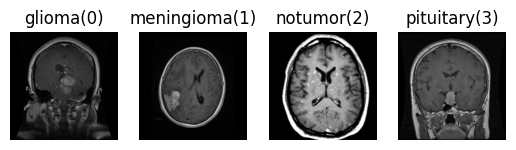

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

class_names = ['glioma(0)', 'meningioma(1)', 'notumor(2)', 'pituitary(3)']

newsize = (224, 224)
img_glioma = Image.open('/content/braintumor/Training/glioma/Tr-gl_0026.jpg').resize(newsize)
img_meningioma = Image.open('/content/braintumor/Training/meningioma/Tr-meTr_0007.jpg').resize(newsize)
img_healthy = Image.open('/content/braintumor/Training/notumor/Tr-noTr_0003.jpg').resize(newsize)
img_pituitary = Image.open('/content/braintumor/Training/pituitary/Tr-piTr_0002.jpg').resize(newsize)
plt.subplot(1,4,1), plt.axis('OFF'), plt.title(class_names[0]), plt.imshow(img_glioma)
plt.subplot(1,4,2), plt.axis('OFF'),plt.title(class_names[1]), plt.imshow(img_meningioma)
plt.subplot(1,4,3), plt.axis('OFF'),plt.title(class_names[2]), plt.imshow(img_healthy)
plt.subplot(1,4,4), plt.axis('OFF'),plt.title(class_names[3]), plt.imshow(img_pituitary);

Dataloader

In [ ]:
import os
import sys
from torchvision import datasets
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from collections import Counter

# Set a fixed seed for reproducibility
seed = 42
torch.manual_seed(seed)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

dataset_ = datasets.ImageFolder(root='/content/braintumor/Training', transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize,
]))

# Define split ratios
train_ratio = 0.8
val_ratio = 0.2

# Calculate lengths for each split
total_size = len(dataset_)
train_size = int(total_size * train_ratio)
val_size = total_size - train_size

# Perform the split
train_split, val_split = torch.utils.data.random_split(dataset_, [train_size, val_size])

# Mapping of class indices to class names
class_to_idx = dataset_.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Print split information
print(f"Total samples: {len(dataset_)}")
print(f"Training samples: {len(train_split)}")
print(f"Validation samples: {len(val_split)}")
print(f"Mapping of class: {idx_to_class}")

Total samples: 5712
Training samples: 4569
Validation samples: 1143
Mapping of class: {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


#Evaluation on labelled dataset
The training process of ResNet model can be found here: https://github.com/mobarakol/AI_Medical_Imaging/blob/main/Active_Learning_Training_ReseNet.ipynb<br>

Download the pretrained weights:

In [ ]:
!gdown 1rs1N_PQ9ZWRjBSwbsFviOgvAP8cYeQNU

Downloading...
From: https://drive.google.com/uc?id=1rs1N_PQ9ZWRjBSwbsFviOgvAP8cYeQNU
To: /content/best_model_4.pth.tar
100% 85.3M/85.3M [00:02<00:00, 41.2MB/s]


Evaluate the performance:

In [ ]:
from torchvision import models
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")

def evaluate(model, valid_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 4
validloader = DataLoader(val_split, batch_size=128, shuffle=False, num_workers=2)

model = models.resnet34(weights=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)
model.load_state_dict(torch.load('best_model_4.pth.tar'))
accuracy = evaluate(model, validloader)
print('accuracy:{.4f}'.format(accuracy))

accuracy: 0.9641294838145232


#Active Learning on new dataset:

Download new dataset

In [ ]:
!gdown 1TdJk-0Gu4e9C-T1dN2t-U6glDKoEhFFt
!unzip -q braintumor_v2.zip

Downloading...
From: https://drive.google.com/uc?id=1TdJk-0Gu4e9C-T1dN2t-U6glDKoEhFFt
To: /content/braintumor_v2.zip
100% 25.6M/25.6M [00:01<00:00, 24.3MB/s]


Visualizing new dataset:

total images: 1311


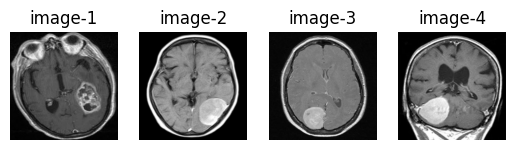

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
img_path_all = glob('braintumor_v2/*/*.jpg')
print('total images:', len(img_path_all))

class_names = ['image-1', 'image-2', 'image-3', 'image-4']

newsize = (224, 224)
img_glioma = Image.open('/content/braintumor_v2/meningioma/Te-meTr_0001.jpg').resize(newsize)
img_meningioma = Image.open('/content/braintumor_v2/meningioma/Te-meTr_0004.jpg').resize(newsize)
img_healthy = Image.open('/content/braintumor_v2/meningioma/Te-me_0010.jpg').resize(newsize)
img_pituitary = Image.open('/content/braintumor_v2/meningioma/Te-me_0020.jpg').resize(newsize)
plt.subplot(1,4,1), plt.axis('OFF'), plt.title(class_names[0]), plt.imshow(img_glioma)
plt.subplot(1,4,2), plt.axis('OFF'),plt.title(class_names[1]), plt.imshow(img_meningioma)
plt.subplot(1,4,3), plt.axis('OFF'),plt.title(class_names[2]), plt.imshow(img_healthy)
plt.subplot(1,4,4), plt.axis('OFF'),plt.title(class_names[3]), plt.imshow(img_pituitary);

Uncertainty-based sampling:

Sample size of new dataset: 1311
Average entropy: 0.2418
Max entropy: 1.2759
Min entropy: 0.0035
Number of high-uncertainty samples selected: 131


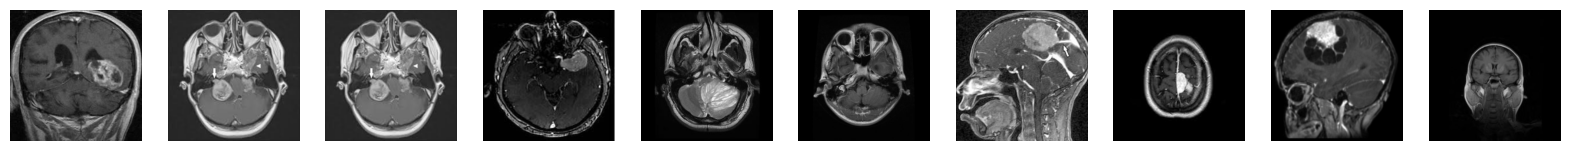

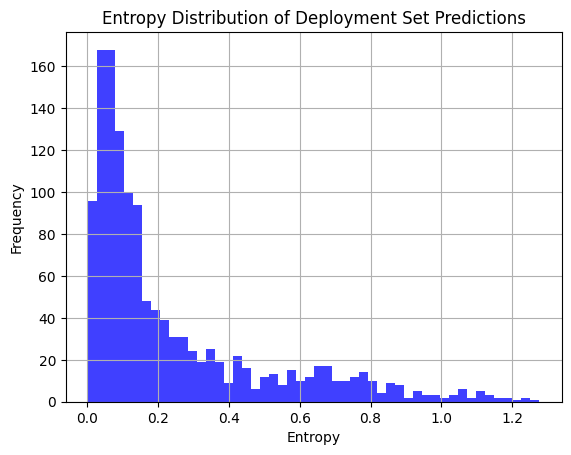

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import warnings
warnings.filterwarnings("ignore")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the function to get entropy-based uncertainty
def get_uncertainty(model, dataloader):
    model.eval()
    entropy_list = []
    indices_list = []  # Store indices to map back to dataset

    with torch.no_grad():
        for batch_idx, (inputs, _) in enumerate(dataloader):  # Ignore targets if unavailable
            inputs = inputs.to(device)

            # Get model outputs (logits)
            outputs = model(inputs)

            # Convert logits to probabilities
            probabilities = F.softmax(outputs, dim=1)

            # Compute entropy: H(p) = -sum(p * log(p))
            entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-10), dim=1)

            # Store entropy values and sample indices
            start_idx = batch_idx * dataloader.batch_size
            entropy_list.extend(entropy.cpu().numpy())
            indices_list.extend(range(start_idx, start_idx + len(inputs)))

    entropy_array = np.array(entropy_list)
    return entropy_array, indices_list

# Prepare dataset
new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

print('Sample size of new dataset:', len(new_dataset))
newdataloader = DataLoader(new_dataset, batch_size=128, shuffle=False, num_workers=2)

# Prepare model
num_classes = len(new_dataset.classes)
model = models.resnet34(weights=True)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.to(device)
model.load_state_dict(torch.load('best_model_4.pth.tar', map_location=device))

# Get uncertainty values and indices
entropy_array, sample_indices = get_uncertainty(model, newdataloader)

# Print some statistics about uncertainty
print(f"Average entropy: {np.mean(entropy_array):.4f}")
print(f"Max entropy: {np.max(entropy_array):.4f}")
print(f"Min entropy: {np.min(entropy_array):.4f}")

# Sort indices based on entropy values (descending order)
sorted_indices = np.argsort(entropy_array)[::-1]  # Sort in descending order

# Select the top 10% samples
top_10_percent = int(0.10 * len(new_dataset))
high_uncertainty_indices = [sample_indices[i] for i in sorted_indices[:top_10_percent]]

# Create a new dataset with high-uncertainty samples
high_uncertainty_subset = Subset(new_dataset, high_uncertainty_indices)

# Retrieve paths of the high-uncertainty samples
all_image_paths = [new_dataset.samples[i][0] for i in range(len(new_dataset))]
high_uncertainty_image_paths = [all_image_paths[idx] for idx in high_uncertainty_indices]

# Print the number of selected high-uncertainty samples
print(f"Number of high-uncertainty samples selected: {len(high_uncertainty_subset)}")

# Create DataLoader for the selected subset (optional)
high_uncertainty_loader = DataLoader(high_uncertainty_subset, batch_size=64, shuffle=False)


# Function to visualize the most uncertain samples after denormalization
def visualize_high_uncertainty_samples( indices, paths, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

    for i, img_path in enumerate(paths[:num_samples]):
        image = Image.open(img_path)
        resized_image = image.resize((224, 224))
        axes[i].imshow(resized_image)
        axes[i].axis('off')

    plt.show()

# Visualize top 10 highest uncertainty samples with their file paths
visualize_high_uncertainty_samples( high_uncertainty_indices, high_uncertainty_image_paths)

# Print some statistics about uncertainty
plt.hist(entropy_array, bins=50, alpha=0.75, color='blue')
plt.title("Entropy Distribution of Deployment Set Predictions")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

#Task: Implement a Active Learning Pipeline with Uncertainty Based Sampling
Retrain the model on 10% highest uncertain samples after labeling them<br>
Find the comments "#Add your code"

In [ ]:
import os
import sys
import argparse
from torchvision import datasets
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset
import random
import numpy as np
import torch

def set_seed(seed):
    """
    Fix all random seeds for reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a fixed seed for reproducibility
set_seed(42)
#Set GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def get_arguments():
    parser = argparse.ArgumentParser(description='CIFAR-10H Training')
    parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
    parser.add_argument('--lr_schedule', default=0, type=int, help='lr scheduler')
    parser.add_argument('--batch_size', default=128, type=int, help='batch size')
    parser.add_argument('--test_batch_size', default=256, type=int, help='batch size')
    parser.add_argument('--num_epoch', default=5, type=int, help='epoch number')
    parser.add_argument('--num_classes', type=int, default=4, help='number classes')

    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()
    return args

def train(model, trainloader, criterion, optimizer):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

def get_high_uncertained_indices(new_dataset):
    newdataloader = DataLoader(new_dataset, batch_size=128, shuffle=False, num_workers=2)
    model_ = models.resnet34(weights=True)
    model_.fc = nn.Linear(model_.fc.in_features, 4)
    model_.load_state_dict(torch.load('best_model_4.pth.tar', map_location=device))
    model_.to(device)

    model_.eval()
    #Implement remaining code to obtain high_uncertainty_indices with 10% samples
    #Add your code
    #Add your code
    #Add your code
    #Add your code
    #Add your code

    return high_uncertainty_indices


if __name__ == '__main__':
    args = get_arguments()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

    # Prepare original dataset
    dataset_ = datasets.ImageFolder(root='/content/braintumor/Training', transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ]))

    # Define split ratios
    train_ratio = 0.8
    val_ratio = 0.2

    # Calculate lengths for each split
    total_size = len(dataset_)
    train_size = int(total_size * train_ratio)
    val_size = total_size - train_size

    # Perform the split
    train_split, val_split = torch.utils.data.random_split(dataset_, [train_size, val_size])
    print('Training on:', device, 'train sample size:', len(train_split), 'valid sample size:', len(val_split))

    # Prepare new dataset
    new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

    # Get high uncertainity indices
    high_uncertainty_indices = get_high_uncertained_indices(new_dataset)

    # Create a new dataset with high-uncertainty samples
    high_uncertainty_subset = Subset(new_dataset, high_uncertainty_indices)

    # Merge the subsets
    merged_dataset = ConcatDataset([high_uncertainty_subset, train_split])
    print('Training on:', device, 'merged train sample size:', len(merged_dataset), 'valid sample size:', len(val_split))

    # Prepare dataloader
    trainloader = DataLoader(merged_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(val_split, batch_size=args.test_batch_size, shuffle=False, num_workers=2)

    print(dataset_.class_to_idx)

    model = models.resnet34(weights=True)
    model.fc = nn.Linear(model.fc.in_features, args.num_classes)
    model.to(device)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=args.lr, betas=(0.9, 0.999), weight_decay=0.1)
    criterion = nn.CrossEntropyLoss()

    best_epoch, best_acc = 0.0, 0
    for epoch in range(args.num_epoch):
        train(model, trainloader, criterion, optimizer)
        accuracy = test(model, testloader)
        if accuracy > best_acc:
            patience = 0
            best_acc = accuracy
            best_epoch = epoch
            #Save the best model as 'best_model.pth.tar'
            #Add your code

        print('epoch: {}  acc: {:.4f}  best epoch: {}  best acc: {:.4f}'.format(
                epoch, accuracy, best_epoch, best_acc, optimizer.param_groups[0]['lr']))


Training on: cuda train sample size: 4569 valid sample size: 1143
Average entropy: 0.2418
Max entropy: 1.2759
Min entropy: 0.0035
Training on: cuda merged train sample size: 4700 valid sample size: 1143
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
epoch: 0  acc: 0.9816  best epoch: 0  best acc: 0.9816
epoch: 1  acc: 0.9860  best epoch: 1  best acc: 0.9860
epoch: 2  acc: 0.9843  best epoch: 1  best acc: 0.9860
epoch: 3  acc: 0.9886  best epoch: 3  best acc: 0.9886
epoch: 4  acc: 0.9843  best epoch: 3  best acc: 0.9886
